In [1]:
from elasticsearch import Elasticsearch
import urllib3
import pandas as pd
import warnings
from flatten_json import flatten
from helpers import LinkedList
import os


ELASTIC_PASS = os.environ["ES_PASS"]
NODES = [
    "https://esh1p:9200",
    "https://esh2p:9200",
    
]
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


**Connect to Elasticsearch**

In [2]:
es = Elasticsearch(NODES,
    basic_auth=("elastic", ELASTIC_PASS),
    verify_certs=False                       
)


/home/filipzag/.local/lib/python3.9/site-packages/elasticsearch/_sync/client/__init__.py:395: SecurityWarning: Connecting to 'https://esh1p:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/home/filipzag/.local/lib/python3.9/site-packages/elasticsearch/_sync/client/__init__.py:395: SecurityWarning: Connecting to 'https://esh2p:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


**Get data**

In [3]:
process_id = "8980"
index_pattern = "windows"
process_eid = "{f97bd2d6-b164-6393-040c-000000006c00}"
host_name = "WKSIBUDIMLIC.corp.diverto.hr"

q_str = 'event.code: 1 AND host.name: "{}" AND proces.entity_id: "{}"'.format(host_name, process_eid)


## Linked list of linked processes
linked_processes = LinkedList()


def  get_parent_process(process_eid):
    q_str = 'event.code: 1 AND host.name: "{}" AND process.entity_id: "{}"'.format(host_name, process_eid)
    
    response = es.search(index=index_pattern,
          query={"query_string": {
                   "query": q_str }},source = [ "process.name", "process.entity_id", "process.parent.entity_id"] 
          )
    
    if len(response['hits']['hits']) > 0:
        
        linked_processes.insert(response['hits']['hits'][0]['_source']['process']['name'])
        
        
        if response['hits']['hits'][0]['_source']['process']['parent']:
            
            get_parent_process(response['hits']['hits'][0]['_source']['process']['parent']['entity_id'])
        
        
        
get_parent_process(process_eid)

**Print process ancestry**

In [4]:
node = linked_processes.get_head()

while node != None:
    if node.get_next() == None:
        print(node.get_data(),end = "")
    else:
    
        print( node.get_data(),end = " => ")
    node = node.get_next()
    


smss.exe => smss.exe => wininit.exe => services.exe => svchost.exe => raserver.exe

#### Process tree

In [153]:
from helpers2 import Process
import networkx as nx
import matplotlib.pyplot as plt

process_graph = nx.DiGraph()
postions = []
## Query specification


index_pattern = "windows"
process_eid = "{c14b16f5-01b1-639e-3819-000000003900}"
host_name = "DESKTOP-FD5EBH9"


q_str = 'event.code: 1 AND host.name: "{}" AND proces.entity_id: "{}"'.format(host_name, process_eid)



#starting_process = Process(name, process_id)
#process_graph.add_node(starting_process.get_id(), pname = starting_process.get_name())

def get_child_process(process_eid):
    
    
    q_str = 'event.code: 1 AND host.name: "{}" AND process.parent.entity_id: "{}"'.format(host_name, process_eid)
    
    response = es.search(index=index_pattern,
          query={"query_string": {
                   "query": q_str }},source = [ "process.name", "process.entity_id", "process.parent.entity_id"] 
          )
    
    
    if len(response['hits']['hits']) > 0:
        
        for event in response['hits']['hits']:
                
            
            process_graph.add_node(event['_source']['process']['entity_id'], pname = event['_source']['process']['name'], shape = "ellipse")
            process_graph.add_edge(process_eid,event['_source']['process']['entity_id'], weight = 5)
            
            
            get_child_process(event['_source']['process']['entity_id'])

            
            

def  get_parent_process(process_eid):
    
    
    q_str = 'event.code: 1 AND host.name: "{}" AND process.entity_id: "{}"'.format(host_name, process_eid)
    
    
    response = es.search(index=index_pattern,
          query={"query_string": {
                   "query": q_str }},source = [ "process.name", "process.entity_id", "process.parent.entity_id", "process.parent.executable"] 
          )
    
    
    
    if len(response['hits']['hits']) > 0:
        
        target_process = response['hits']['hits'][0]["_source"]
        
        process_graph.add_node(target_process['process']['entity_id'], pname = target_process['process']['name'], shape = "ellipse" )
      
    
        
        if target_process['process']['parent']['executable'] not in ["System", "C:\\Windows\\System32\\userinit.exe"]:
            
            process_graph.add_edge(target_process['process']['parent']['entity_id'], process_eid)  
            get_parent_process(target_process['process']['parent']['entity_id'])
            
            get_child_process(process_eid)
    else:
        
        get_child_process(process_eid)
        
        
        
get_parent_process(process_eid)


**Plot results**

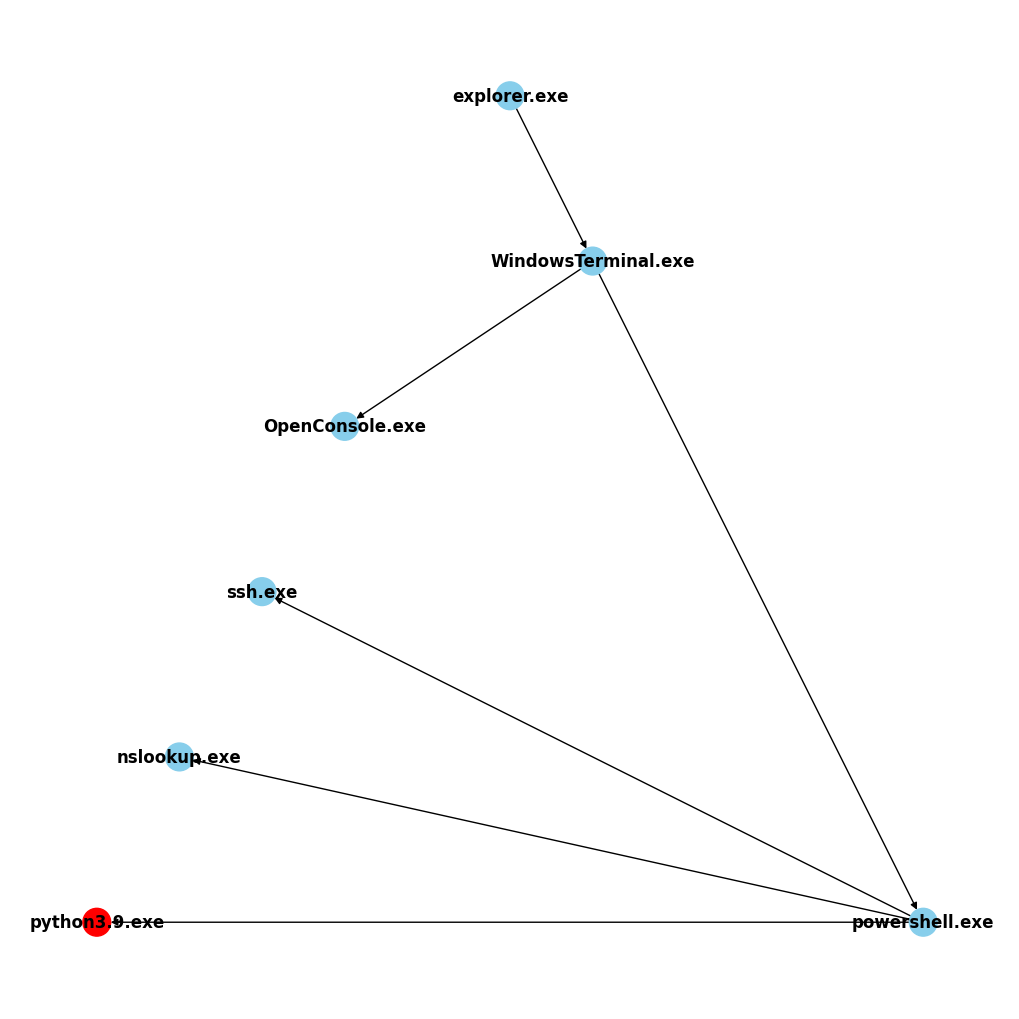

In [159]:

color_map = ['red' if node == process_eid else 'skyblue' for node in process_graph]


labels = nx.get_node_attributes(process_graph, 'pname')

pos = nx.planar_layout(process_graph)
nx.draw(process_graph, with_labels = True, font_weight = 'bold',labels = labels, pos = pos, node_color = color_map,node_size = 400)

